In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math, os, re, sys

In [2]:
# Ignore PyPlot warning.
plt.rcParams.update({'figure.max_open_warning': 0})

# Possible bin angles.
bin_angles = [4, 5, 6, 9, 10, 12, 15, 18, 20, 30, 45]

# List of relevant features and axis names.
wind_features = ['WTP_AW_angle', 'WTP_AW_speed']
boat_speed_feature = 'WTP_SelBoatSpd'
bins_axis_names = ['Wind Angle (˚)', 'Wind Speed (knot)']
boxplot_axis_name = 'Boat Speed (knot)'

In [3]:
def read_csv(fname):
    """Read a CSV file to a Pandas Dataframe"""
    return pd.read_csv(fname, sep=';')

def transform(df, new_cols, regex):
    """Transform the dataset"""
    for col in new_cols:
        filtered = df.filter(regex=(regex.format(col)))
        df[col] = filtered.mean(axis=1)
        df.drop(filtered.columns, axis=1, inplace=True)
    return df

def create_if_not_exist(path):
    """Create a directory if not exist"""
    if not os.path.exists(path):
        os.makedirs(path)

def create_bins(df, dx=bin_angles[0], dy=2, min_thresh=100, tries=0):
    """Create bins"""
    bins = {}
    max_x = 0
    while max_x < 180:
        max_y = 0
        while max_y < math.ceil(df.loc[df[wind_features[1]].idxmax()][wind_features[1]]):
            binned_df = df.query('{0} >= {2} and {0} < {2}+{4} & {1} >= {3} & {1} < {3}+{5}'.format(wind_features[0], wind_features[1], max_x, max_y, dx, dy))
            if len(binned_df) >= int(math.ceil(min_thresh * 0.1)):
                if len(binned_df) < min_thresh:
                    return create_bins(df, dx=bin_angles[tries+1], dy=dy+2, min_thresh=min_thresh, tries=tries+1)
                bins['bin_x{}to{}_y{}to{}'.format(max_x, max_x+dx, max_y, max_y+dy)] = binned_df
            max_y+=dy
        max_x+=dx
    return bins, dx, dy, max_x, max_y

def plot_wind_angle_speed(df, x_start, y_start, x_finish, y_finish, dx, dy, markersize):
    """Plot wind angle-speed space"""
    plt.xlabel(bins_axis_names[0])
    plt.ylabel(bins_axis_names[1])
    plt.plot(df[wind_features[0]].tolist(), df[wind_features[1]].tolist(), 'ko', markersize=markersize)
    plt.xticks(np.arange(x_start, x_finish, dx))
    plt.yticks(np.arange(y_start, y_finish, dy))
    plt.grid(lw=.75)
    plt.tight_layout()
    plt.show()
    plt.clf()

def plot_boxplot(df, column, outliers):
    """Plot boxplot for boat speed"""
    df.boxplot(column=column, showfliers=outliers)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.ylabel(boxplot_axis_name)
    plt.tight_layout()
    plt.show()
    plt.clf()

In [4]:
# Read from CSV.
df = read_csv('./data/datalog-05102017-Full_1Hz.1s_clean.csv')

# Transform the dataset to decrease the number of features.
df = transform(df,
            ['1s_FBM_P_lfwd', '1s_FBM_P_uaft', '1s_FBM_P_ufwd',
            '1s_FBM_S_laft', '1s_FBM_S_lfwd', '1s_FBM_S_uaft', '1s_FBM_S_ufwd',
            '1s_HUL_C_lport', '1s_HUL_C_lstbd', '1s_HUL_C_uport', '1s_HUL_C_ustbd',
            '1s_HUL_P_lport', '1s_HUL_P_lstbd', '1s_HUL_P_uport', '1s_HUL_P_ustbd',
            '1s_HUL_S_lport', '1s_HUL_S_lstbd', '1s_HUL_S_uport', '1s_HUL_S_ustbd',
            '1s_Foil_B_P_01_i', '1s_Foil_B_P_01_o',
            '1s_Foil_B_S_01_i', '1s_Foil_B_S_01_o',
            '1s_Foil_ELE_C_01_p', '1s_Foil_ELE_C_01_s',
            '1s_Foil_ELE_LOAD_P', '1s_Foil_ELE_LOAD_S'],
            '.*{}.*')

# Show examples of the data.
df.head()

,date TU,heure TU,latitude,longitude,RM_RM,WTP_1_MW_angle,WTP_1_MW_speed,WTP_2_MW_angle,WTP_2_MW_speed,WTP_AW_angle,...,1s_HUL_S_uport,1s_HUL_S_ustbd,1s_Foil_B_P_01_i,1s_Foil_B_P_01_o,1s_Foil_B_S_01_i,1s_Foil_B_S_01_o,1s_Foil_ELE_C_01_p,1s_Foil_ELE_C_01_s,1s_Foil_ELE_LOAD_P,1s_Foil_ELE_LOAD_S
0,2017-10-05,10:51:19,47.7274N,3.3709W,6.7,149.2,12.0,2.1,0.0,156,...,18.25,53.75,262.500000,93.928571,-247.285714,-187.071429,11.50,24.00,91.00,121.75
1,2017-10-05,10:51:20,47.7274N,3.3709W,6.7,155.5,12.2,2.1,0.0,156,...,0.25,37.25,285.000000,116.928571,-245.071429,-184.714286,-5.75,6.50,9.00,34.50
2,2017-10-05,10:51:21,47.7274N,3.3709W,6.7,153.7,11.2,2.1,0.0,156,...,0.00,36.50,285.000000,115.928571,-245.428571,-184.857143,-6.25,6.75,8.50,35.00
3,2017-10-05,10:51:22,47.7274N,3.3709W,6.7,144.0,10.7,2.1,0.0,156,...,-0.25,36.00,284.714286,116.357143,-245.785714,-184.714286,-5.75,6.25,9.50,34.50
4,2017-10-05,10:51:23,47.7274N,3.3709W,6.7,144.4,9.9,2.1,0.0,155,...,-0.75,36.75,285.142857,116.285714,-245.285714,-184.857143,-6.25,6.00,7.25,33.75


In [5]:
# Combine positive and negative wind angles.
df.eval('{0} = abs({0})'.format(wind_features[0]), inplace=True)

# Show examples of the derived data.
df.head()[wind_features]

,WTP_AW_angle,WTP_AW_speed
0,156,11.3
1,156,11.3
2,156,11.3
3,156,11.2
4,155,11.0


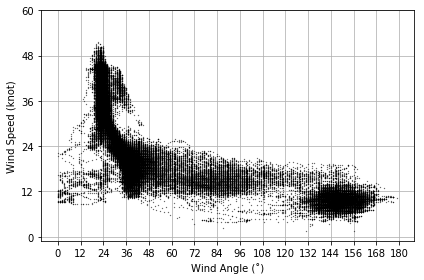

<Figure size 432x288 with 0 Axes>

In [6]:
# Determine the size of the bins using 10 as minimum bin size.
bins, dx, dy, max_x, max_y = create_bins(df, min_thresh=10)

# Plot the resultant bins.
plot_wind_angle_speed(df, 0, 0, max_x+1, max_y+1, dx, dy, 0.25)

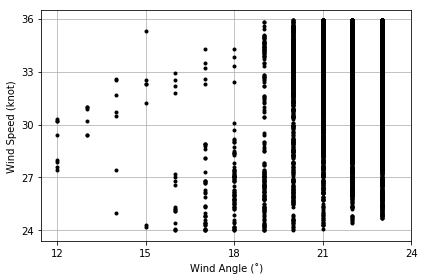

<Figure size 432x288 with 0 Axes>

In [7]:
# Select an example bin (Wind Angle: 12-24˚, Wind Speed: 24-36 Knots).
bin_name = 'bin_x12to24_y24to36'
binned_df = bins[bin_name]
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(r'\d+', bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish+dx, y_finish+dy, dx, dy, 3)

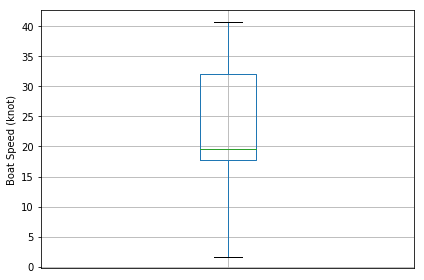

<Figure size 432x288 with 0 Axes>

In [8]:
# Plot the boat speed boxplot. 
plot_boxplot(binned_df, boat_speed_feature, False)

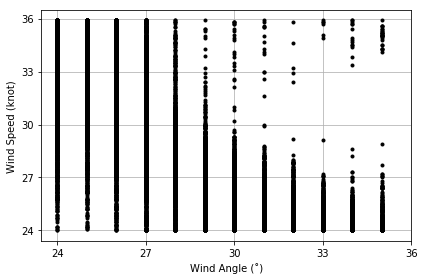

<Figure size 432x288 with 0 Axes>

In [9]:
# Select another example bin (Wind Angle: 24-36˚, Wind Speed: 24-36 Knots).
bin_name = 'bin_x24to36_y24to36'
binned_df = bins[bin_name]
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(r'\d+', bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish+dx, y_finish+dy, dx, dy, 3)

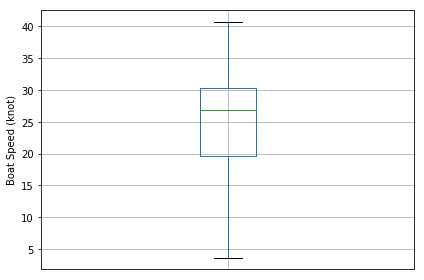

<Figure size 432x288 with 0 Axes>

In [10]:
# Plot the boat speed boxplot. 
plot_boxplot(binned_df, boat_speed_feature, False)

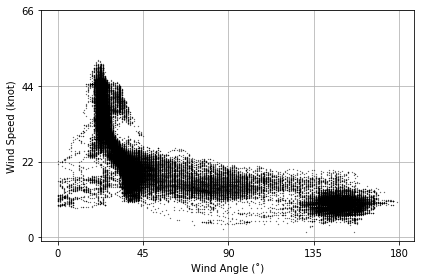

<Figure size 432x288 with 0 Axes>

In [11]:
# Determine another size of the bins using 100 as minimum bin size.
bins, dx, dy, max_x, max_y = create_bins(df, min_thresh=100)

# Plot the resultant bins.
plot_wind_angle_speed(df, 0, 0, max_x+1, max_y+1, dx, dy, 0.25)

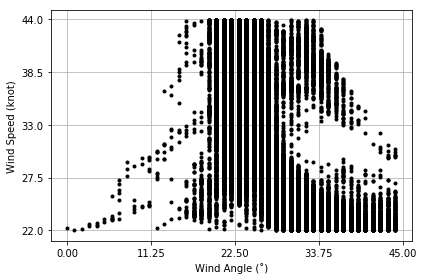

<Figure size 432x288 with 0 Axes>

In [12]:
# Select an example bin (Wind Angle: 0-45˚, Wind Speed: 22-44 Knots).
bin_name = 'bin_x0to45_y22to44'
binned_df = bins[bin_name]
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(r'\d+', bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish+dx, y_finish+dy, dx, dy, 3)

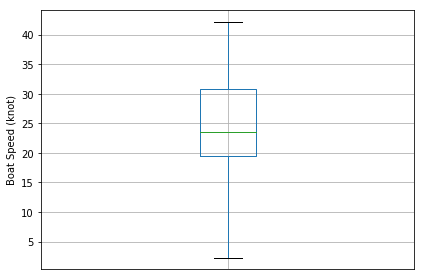

<Figure size 432x288 with 0 Axes>

In [13]:
# Plot the boat speed boxplot. 
plot_boxplot(binned_df, boat_speed_feature, False)

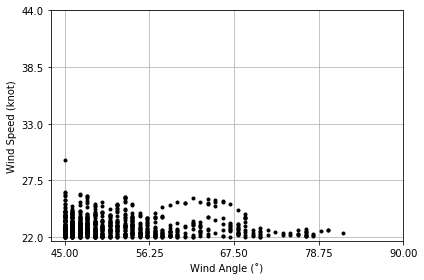

<Figure size 432x288 with 0 Axes>

In [14]:
# Select another example bin (Wind Angle: 45-90˚, Wind Speed: 22-44 Knots).
bin_name = 'bin_x45to90_y22to44'
binned_df = bins[bin_name]
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(r'\d+', bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish+dx, y_finish+dy, dx, dy, 3)

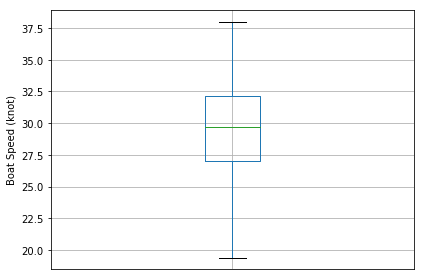

<Figure size 432x288 with 0 Axes>

In [15]:
# Plot the boat speed boxplot. 
plot_boxplot(binned_df, boat_speed_feature, False)